In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score

In [2]:
csv_data = '''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

df = pd.read_csv(StringIO(csv_data))
print(df)

      A     B     C    D
0   1.0   2.0   3.0  4.0
1   5.0   6.0   NaN  8.0
2  10.0  11.0  12.0  NaN


In [3]:
print(df.isnull().sum())

A    0
B    0
C    1
D    1
dtype: int64


In [4]:
print(df.dropna())

     A    B    C    D
0  1.0  2.0  3.0  4.0


In [5]:
print(df.dropna(axis=1))

      A     B
0   1.0   2.0
1   5.0   6.0
2  10.0  11.0


In [6]:
# only drop rows where all columns are NaN
print(df.dropna(how='all'))

      A     B     C    D
0   1.0   2.0   3.0  4.0
1   5.0   6.0   NaN  8.0
2  10.0  11.0  12.0  NaN


In [7]:
# drop rows that have not at least 4 non-NaN values
print(df.dropna(thresh=4))

     A    B    C    D
0  1.0  2.0  3.0  4.0


In [8]:
# only drop rows where NaN appear in specific columns (here: 'C')
print(df.dropna(subset=['C']))

      A     B     C    D
0   1.0   2.0   3.0  4.0
2  10.0  11.0  12.0  NaN


In [9]:
## Imputing missing values
imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df)
imputed_data = imr.transform(df.values)
print(imputed_data)

[[  1.    2.    3.    4. ]
 [  5.    6.    7.5   8. ]
 [ 10.   11.   12.    6. ]]


In [10]:
# Handling categorical data
df = pd.DataFrame([['green', 'M', 10.1, 'class1'],
                   ['red', 'L', 13.5, 'class2'],
                   ['blue', 'XL', 15.3, 'class1']])

df.columns = ['color', 'size', 'price', 'classlabel']
print(df)

   color size  price classlabel
0  green    M   10.1     class1
1    red    L   13.5     class2
2   blue   XL   15.3     class1


In [11]:
## Mapping ordinal features
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}

df['size'] = df['size'].map(size_mapping)
print(df)

inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

   color  size  price classlabel
0  green     1   10.1     class1
1    red     2   13.5     class2
2   blue     3   15.3     class1


0     M
1     L
2    XL
Name: size, dtype: object

In [12]:
## Encoding class labels
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
print(class_mapping)

{'class2': 1, 'class1': 0}


In [13]:
df['classlabel'] = df['classlabel'].map(class_mapping)
print(df)

   color  size  price  classlabel
0  green     1   10.1           0
1    red     2   13.5           1
2   blue     3   15.3           0


In [14]:
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
print(df)

   color  size  price classlabel
0  green     1   10.1     class1
1    red     2   13.5     class2
2   blue     3   15.3     class1


In [15]:
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
print(y)

[0 1 0]


In [16]:
print(class_le.inverse_transform(y))

['class1' 'class2' 'class1']


In [17]:
## Performing one-hot encoding on nominal features
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
print(X)

[[1 1 10.1]
 [2 2 13.5]
 [0 3 15.3]]


In [18]:
ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()

array([[  0. ,   1. ,   0. ,   1. ,  10.1],
       [  0. ,   0. ,   1. ,   2. ,  13.5],
       [  1. ,   0. ,   0. ,   3. ,  15.3]])

In [19]:
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0.0,1.0,0.0
1,13.5,2,0.0,0.0,1.0
2,15.3,3,1.0,0.0,0.0


In [20]:
# Partitioning a dataset in training and test sets
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [21]:
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [22]:
# Bringing features onto the same scale
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)
print(X_test_norm[0,:])

[ 0.72849462  0.16386555  0.47849462  0.29896907  0.52173913  0.53956835
  0.74311927  0.13461538  0.37974684  0.4364852   0.32478632  0.70695971
  0.60566802]


In [23]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
print(X_test_std[0,:])

[ 0.94841977 -0.63042822 -0.4110476  -0.87677804  1.22679643  0.57147571
  0.95620726 -1.24682729  0.01258759  0.36299992 -0.15283642  0.83141032
  1.01828164]


In [24]:
ex = pd.DataFrame([0, 1, 2, 3, 4, 5])
# standardize
ex[1] = (ex[0] - ex[0].mean()) / ex[0].std(ddof=0)

# Please note that pandas uses ddof=1 (sample standard deviation)
# by default, whereas NumPy's std method and the StandardScaler
# uses ddof=0 (population standard deviation)

# normalize
ex[2] = (ex[0] - ex[0].min()) / (ex[0].max() - ex[0].min())
ex.columns = ['input', 'standardized', 'normalized']
print(ex)

   input  standardized  normalized
0      0      -1.46385         0.0
1      1      -0.87831         0.2
2      2      -0.29277         0.4
3      3       0.29277         0.6
4      4       0.87831         0.8
5      5       1.46385         1.0


In [25]:
# Selecting meaningful features
## Sparse solutions with L1-regularization
lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))
print('lr.intercept:', lr.intercept_)
print('lr.coef:', lr.coef_)

Training accuracy: 0.983870967742
Test accuracy: 0.981481481481
lr.intercept: [-0.38379899 -0.15807827 -0.70044603]
lr.coef: [[ 0.27992659  0.          0.         -0.02796699  0.          0.
   0.70990449  0.          0.          0.          0.          0.
   1.23691923]
 [-0.64394169 -0.06877714 -0.05720455  0.          0.          0.          0.
   0.          0.         -0.92685282  0.06015438  0.         -0.3710419 ]
 [ 0.          0.06158088  0.          0.          0.          0.
  -0.63529936  0.          0.          0.49774492 -0.35847421 -0.57174624
   0.        ]]


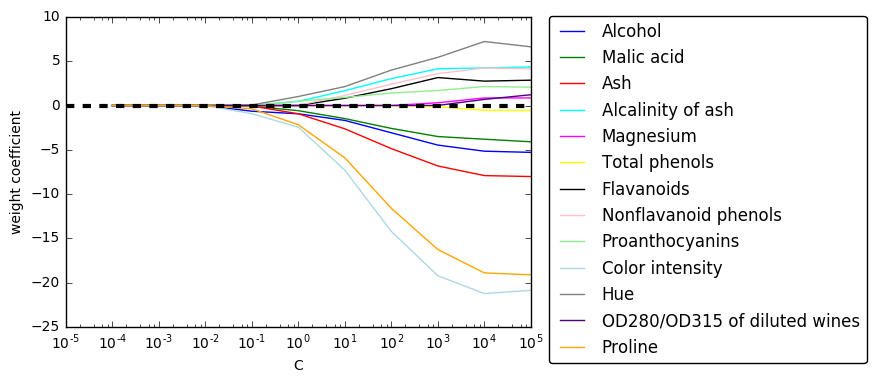

In [26]:
fig = plt.figure()
ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan',
          'magenta', 'yellow', 'black',
          'pink', 'lightgreen', 'lightblue',
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10. ** c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10. ** c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10 ** (-5), 10 ** 5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
# plt.savefig('./figures/l1_path.png', dpi=300)
plt.show()

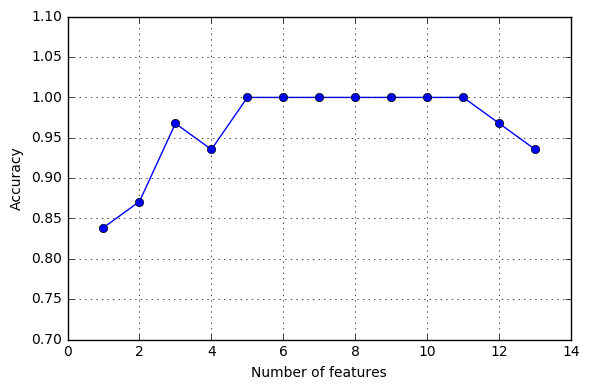

In [27]:
class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):

        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train,
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

knn = KNeighborsClassifier(n_neighbors=2)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

In [28]:
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k5], y_test))

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')
Training accuracy: 0.983870967742
Test accuracy: 0.944444444444
Training accuracy: 0.959677419355
Test accuracy: 0.962962962963


 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids                     0.150948
 4) OD280/OD315 of diluted wines   0.131987
 5) Alcohol                        0.106589
 6) Hue                            0.078243
 7) Total phenols                  0.060718
 8) Alcalinity of ash              0.032033
 9) Malic acid                     0.025400
10) Proanthocyanins                0.022351
11) Magnesium                      0.022078
12) Nonflavanoid phenols           0.014645
13) Ash                            0.013916


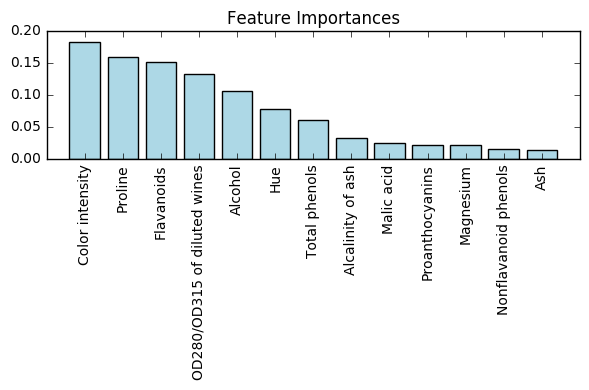

 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids                     0.150948


In [30]:
# Assessing Feature Importances with Random Forests
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=10000,
                                random_state=0,
                                n_jobs=-1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        color='lightblue',
        align='center')

plt.xticks(range(X_train.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
# plt.savefig('./random_forest.png', dpi=300)
plt.show()

from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.15, prefit=True)
X_selected = sfm.transform(X_train)

X_selected.shape


for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))